In [156]:
#!/usr/bin/env python3
import pandas as pd
import requests
import time
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
from tqdm import tqdm
import elasticsearch
import os
import sys
import pickle
# pd.options.plotting.backend = "plotly"

In [103]:
avg_over_min = 1
days_look_back = 7

en_date = datetime.now()
st_date = (datetime.now() - timedelta(days=days_look_back))

en_date_dt = en_date.astimezone(pytz.timezone('America/New_York'))
st_date_dt = (st_date - timedelta(days=days_look_back)).astimezone(pytz.timezone('America/New_York'))

st_date_utc = st_date.astimezone(pytz.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')
en_date_utc = en_date.astimezone(pytz.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')

In [111]:
en_date = '2022-06-07T00:00:00'
st_date = '2022-04-13T00:00:00'

en_date_dt = datetime.strptime(en_date, '%Y-%m-%dT%H:%M:%S').astimezone(pytz.timezone('America/New_York'))
st_date_dt = datetime.strptime(st_date, '%Y-%m-%dT%H:%M:%S').astimezone(pytz.timezone('America/New_York'))

st_date_utc = datetime.strptime(st_date, '%Y-%m-%dT%H:%M:%S').astimezone(pytz.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')
en_date_utc = datetime.strptime(en_date, '%Y-%m-%dT%H:%M:%S').astimezone(pytz.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')

In [112]:
import glob
weather_station_url = 'https://www.wunderground.com/dashboard/pws/KNYNEWYO1566'
with open('stations.txt', 'w')as fp:
    fp.write(weather_station_url)
    
filePath = glob.glob('*.csv')
for i in filePath:
    if os.path.exists(i):
        os.remove(i)
    else:
        print("Can not delete the file as it doesn't exists")
py_path = sys.executable
os.system(py_path + ' weather_scraper.py --st_date %s --en_date %s' % (st_date_dt.date(), en_date_dt.date()))

0

In [5]:
# Import and format Praxis data
uri = 'https://aws.southcoastscience.com/topicMessages?topic=nyu/brooklyn/loc/3/particulates&' \
'startTime=%s&endTime=%s&checkpoint=**:/%i:00' \
% (st_date_utc, en_date_utc, avg_over_min)
print(uri)
praxis_df = pd.DataFrame([])

while uri != '':
    header = {"authorization": "api-key nyu-brooklyn"}
    response = requests.get(uri, headers=header)
    json = response.json()

    data = {}

    data['ts'] = pd.to_datetime([ele['rec'] for ele in json['Items']]).tz_convert(tz='US/Eastern')

    data['praxis_pm1_vals'] = [ele['val']['pm1'] for ele in json['Items']]
    data['praxis_pm2p5_vals'] = [ele['val']['pm2p5'] for ele in json['Items']]
    data['praxis_pm10_vals'] = [ele['val']['pm10'] for ele in json['Items']]

    data['praxis_pm1_vals_adj'] = [ele['exg']['rn20']['pm1'] for ele in json['Items']]
    data['praxis_pm2p5_vals_adj'] = [ele['exg']['rn20']['pm2p5'] for ele in json['Items']]
    data['praxis_pm10_vals_adj'] = [ele['exg']['rn20']['pm10'] for ele in json['Items']]

#     praxis_df = pd.DataFrame(data).set_index('ts').resample(avg_over).mean()

    if 'next' in json:
        uri = json['next']
    else:
        uri = ''
    praxis_df = pd.concat([praxis_df, pd.DataFrame(data)])
    
    time.sleep(0.5)
praxis_df = praxis_df.set_index('ts').resample('%iT' % avg_over_min).mean()

https://aws.southcoastscience.com/topicMessages?topic=nyu/brooklyn/loc/3/particulates&startTime=2022-04-13T04:00:00Z&endTime=2022-06-07T04:00:00Z&checkpoint=**:/1:00


In [117]:
praxis_df

,praxis_pm1_vals,praxis_pm2p5_vals,praxis_pm10_vals,praxis_pm1_vals_adj,praxis_pm2p5_vals_adj,praxis_pm10_vals_adj
ts,,,,,,
2022-04-13 00:04:00-04:00,1.9,3.7,9.6,9.2,11.6,22.8
2022-04-13 00:05:00-04:00,1.9,3.5,14.2,9.6,10.9,21.3
2022-04-13 00:06:00-04:00,2.0,3.6,11.5,10.0,11.0,20.7
2022-04-13 00:07:00-04:00,2.1,3.5,9.3,9.8,11.0,19.4
2022-04-13 00:08:00-04:00,2.1,4.2,7.8,10.5,11.6,23.5
...,...,...,...,...,...,...
2022-06-06 11:45:00-04:00,0.7,2.6,11.5,3.9,5.9,22.8
2022-06-06 11:46:00-04:00,0.8,2.6,13.6,3.8,6.1,23.5
2022-06-06 11:47:00-04:00,0.8,2.6,9.8,3.9,5.9,18.0


In [118]:
df_weather = pd.read_csv(glob.glob('*.csv')[0])

In [119]:
# df_weather['ts'] = pd.to_datetime(df_weather['Date'] + ' ' + df_weather['Time']).dt.tz_localize(tz='US/Eastern')
# df_weather = df_weather.set_index('ts').resample('%iT' % avg_over_min).mean()
# df_weather = df_weather.fillna(df_weather.mean())
df_weather['ts'] = pd.to_datetime(df_weather["Date"] + ' ' + df_weather['Time']).dt.tz_localize(tz='US/Eastern')
df_weather = df_weather.set_index('ts').resample('%iT' % avg_over_min).mean().fillna(method = 'ffill').fillna(method = 'bfill')
df_weather = df_weather.loc[st_date:en_date]


In [120]:
# df_weather.tail() 

df_weather = df_weather[['Temperature_C', 'Humidity_%']]
df_weather

,Temperature_C,Humidity_%
ts,,
2022-04-13 00:02:00-04:00,17.78,90.0
2022-04-13 00:03:00-04:00,17.78,90.0
2022-04-13 00:04:00-04:00,17.78,90.0
2022-04-13 00:05:00-04:00,17.78,90.0
2022-04-13 00:06:00-04:00,17.78,90.0
...,...,...
2022-06-06 23:56:00-04:00,20.89,44.0
2022-06-06 23:57:00-04:00,20.89,44.0
2022-06-06 23:58:00-04:00,20.89,44.0


In [121]:
praxis_df = praxis_df.loc[str(df_weather.index[0]):str(df_weather.index[-1])]
praxis_df

,praxis_pm1_vals,praxis_pm2p5_vals,praxis_pm10_vals,praxis_pm1_vals_adj,praxis_pm2p5_vals_adj,praxis_pm10_vals_adj
ts,,,,,,
2022-04-13 00:04:00-04:00,1.9,3.7,9.6,9.2,11.6,22.8
2022-04-13 00:05:00-04:00,1.9,3.5,14.2,9.6,10.9,21.3
2022-04-13 00:06:00-04:00,2.0,3.6,11.5,10.0,11.0,20.7
2022-04-13 00:07:00-04:00,2.1,3.5,9.3,9.8,11.0,19.4
2022-04-13 00:08:00-04:00,2.1,4.2,7.8,10.5,11.6,23.5
...,...,...,...,...,...,...
2022-06-06 11:45:00-04:00,0.7,2.6,11.5,3.9,5.9,22.8
2022-06-06 11:46:00-04:00,0.8,2.6,13.6,3.8,6.1,23.5
2022-06-06 11:47:00-04:00,0.8,2.6,9.8,3.9,5.9,18.0


In [11]:
GROUP = time.time()

def scroll(es, index, body, scroll='2m', size=1000, timeout=25, **kw):
    if isinstance(timeout, int):
        timeout = '{}s'.format(int(timeout))
    page = es.search(index=index, body=body, scroll=scroll, size=size, timeout=timeout, **kw)
    scroll_id, hits = page['_scroll_id'], page['hits']['hits']
    while len(hits):
        yield hits
        page = es.scroll(scroll_id=scroll_id, scroll=scroll)
        scroll_id, hits = page['_scroll_id'], page['hits']['hits']
        
def sensor_query(key=None, nodeid=None, start=None, end=None, k_time="time", group=GROUP):
    match = []
    if key and nodeid:
        match.append({"term": {f'{key}.keyword': nodeid}})
    end = end or 'now'
    if start:
        match.append({"range" : {k_time : {"gte" : start, "lte" : end}}})
    elif end:
        match.append({"range" : {k_time : {"lte" : end}}})
    return { "query": { "bool": {"must": match} } } if match else {}

def download_sensor_data(table, key=None, nodeid=None, start=None, end=None, save=True, k_time='time', **kw):
    query = sensor_query(key, nodeid, start, end, k_time=k_time, **kw)
    print(query)
    
    def pull():
        with tqdm(scroll(es, table, query)) as pbar:
            for i, hits in enumerate(pbar):
                hits = [h['_source'] for h in hits]
                times = [h[k_time] for h in hits]
                pbar.write('{}. n hits: {}. {} - {}'.format(i, len(hits), min(times), max(times)))
                for h in hits:
                    yield h
    if not save:
        return list(pull())

    fname = 'data/{}/{}.json'.format(group, nodeid or table)
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    print(f'Pulling node={nodeid} for ({start} -> {end}) ... saving to {fname}')
    with open(fname, 'w') as f:
        for h in pull():
            f.write(json.dumps(h) + '\n')
    print('all done!')
    return fname

In [30]:
from importlib import reload
import settings
reload(settings)
es = elasticsearch.Elasticsearch('https://es.master1.sonycproject.com', http_auth=('elastic', settings.es_password))
ss = download_sensor_data('status', 'fqdn', 'sonycnode-dca632ceb490', start=st_date_utc, end=en_date_utc, save=False)
data = {}
data['ts'] = pd.to_datetime([datetime.fromtimestamp(int(ele['aq']['dt'])) for ele in ss if ele['aq'] is not None]).tz_localize(tz='US/Eastern')
    
data['piera7100_pm1_vals'] = [ele['aq']['PM1.0'] for ele in ss if ele['aq'] is not None]
data['piera7100_pm2p5_vals'] = [ele['aq']['PM2.5'] for ele in ss if ele['aq'] is not None]
data['piera7100_pm10_vals'] = [ele['aq']['PM10'] for ele in ss if ele['aq'] is not None]

piera7100_df = pd.DataFrame(data)
    
piera7100_df = piera7100_df.set_index('ts').resample('%iT' % avg_over_min).mean()
# purple_df = purple_df.set_index('ts').resample('%iT' % avg_over_min).mean()
# piera7100_df = piera7100_df.loc[st_date_dt:en_date_dt]

{'query': {'bool': {'must': [{'term': {'fqdn.keyword': 'sonycnode-dca632ceb490'}}, {'range': {'time': {'gte': '2022-04-13T04:00:00Z', 'lte': '2022-06-07T04:00:00Z'}}}]}}}


0it [00:00, ?it/s]

0. n hits: 1000. 2022-04-22T11:08:44.952479 - 2022-04-22T18:32:20.064899
1. n hits: 1000. 2022-04-22T10:32:29.556688 - 2022-04-22T19:32:35.718586
2. n hits: 1000. 2022-04-20T20:47:08.801251 - 2022-04-22T19:58:46.082006
3. n hits: 1000. 2022-04-20T16:30:25.871010 - 2022-04-21T02:52:24.156497
4. n hits: 1000. 2022-04-20T17:57:41.881690 - 2022-04-23T13:15:37.680733
5. n hits: 1000. 2022-04-23T09:48:55.452551 - 2022-04-23T15:08:13.819095
6. n hits: 1000. 2022-04-23T10:22:25.828673 - 2022-04-23T15:52:19.366968
7. n hits: 1000. 2022-04-22T23:47:48.741533 - 2022-04-23T15:52:29.361348
8. n hits: 1000. 2022-04-22T23:48:03.680681 - 2022-04-23T03:59:21.541887
9. n hits: 1000. 2022-04-23T02:11:20.252064 - 2022-04-23T03:59:41.524298
10. n hits: 1000. 2022-04-23T03:20:31.081681 - 2022-04-23T11:50:26.811938
11. n hits: 1000. 2022-04-23T09:49:00.376908 - 2022-04-23T17:46:35.534964
12. n hits: 1000. 2022-04-23T11:50:41.771959 - 2022-04-23T18:06:15.744929
13. n hits: 1000. 2022-04-23T12:16:42.095582 - 2

111. n hits: 1000. 2022-04-14T14:07:58.110111 - 2022-04-14T20:57:32.618464
112. n hits: 1000. 2022-04-14T18:57:01.300749 - 2022-04-14T22:50:58.927069
113. n hits: 1000. 2022-04-13T18:15:05.594284 - 2022-04-14T23:24:34.277714
114. n hits: 1000. 2022-04-13T12:37:03.548750 - 2022-04-13T19:45:36.597587
115. n hits: 1000. 2022-04-13T14:39:13.091825 - 2022-04-13T23:41:29.066679
116. n hits: 1000. 2022-04-13T21:48:52.765421 - 2022-04-14T00:32:39.571432
117. n hits: 1000. 2022-04-13T23:28:03.892531 - 2022-04-14T02:19:55.657671
118. n hits: 1000. 2022-04-13T23:42:34.057554 - 2022-04-14T02:50:00.988082
119. n hits: 1000. 2022-04-14T02:38:55.895881 - 2022-04-18T15:19:03.113447
120. n hits: 1000. 2022-04-18T07:45:08.021110 - 2022-04-18T15:19:13.173741
121. n hits: 1000. 2022-04-18T01:42:09.216502 - 2022-04-18T08:53:33.776711
122. n hits: 1000. 2022-04-18T01:57:04.298989 - 2022-04-18T08:57:43.809088
123. n hits: 1000. 2022-04-18T02:07:19.416034 - 2022-04-18T17:14:29.528454
124. n hits: 1000. 2022-0

221. n hits: 1000. 2022-04-22T04:45:25.851564 - 2022-04-24T22:58:54.839415
222. n hits: 1000. 2022-04-24T21:10:48.625253 - 2022-04-25T00:47:06.056251
223. n hits: 1000. 2022-04-24T21:22:53.769323 - 2022-04-25T00:57:21.200708
224. n hits: 1000. 2022-04-25T00:57:06.172230 - 2022-04-25T03:47:58.123219
225. n hits: 1000. 2022-04-25T01:27:21.534573 - 2022-04-25T03:22:22.880837
226. n hits: 1000. 2022-04-23T18:47:56.191880 - 2022-04-25T04:25:28.543119
227. n hits: 1000. 2022-04-23T18:45:31.174335 - 2022-04-23T22:28:03.511939
228. n hits: 1000. 2022-04-16T13:45:45.910467 - 2022-04-23T23:11:03.922643
229. n hits: 1000. 2022-04-16T10:39:03.871266 - 2022-04-17T01:15:08.306830
230. n hits: 1000. 2022-04-16T10:25:18.680954 - 2022-04-16T21:49:06.077561
231. n hits: 1000. 2022-04-15T13:19:33.034843 - 2022-04-17T01:41:08.595973
232. n hits: 1000. 2022-04-15T04:22:37.427569 - 2022-04-15T14:42:44.066375
233. n hits: 1000. 2022-04-15T02:31:26.211780 - 2022-04-15T14:45:09.141908
234. n hits: 1000. 2022-0

331. n hits: 1000. 2022-05-09T11:54:17.135869 - 2022-05-09T15:52:00.065073
332. n hits: 1000. 2022-05-09T11:54:27.161798 - 2022-05-09T14:13:23.814989
333. n hits: 1000. 2022-05-09T12:15:32.394024 - 2022-05-09T17:15:56.020386
334. n hits: 1000. 2022-05-09T15:52:55.078842 - 2022-05-09T18:37:25.794680
335. n hits: 1000. 2022-05-09T17:56:37.549867 - 2022-05-09T20:24:41.937334
336. n hits: 1000. 2022-05-09T06:09:07.842570 - 2022-05-09T21:20:07.470492
337. n hits: 1000. 2022-05-07T21:33:58.856043 - 2022-05-09T21:20:47.473979
338. n hits: 1000. 2022-05-07T21:34:13.824903 - 2022-05-08T00:08:50.879652
339. n hits: 1000. 2022-05-07T21:36:23.839685 - 2022-05-08T02:30:57.739915
340. n hits: 1000. 2022-05-08T00:08:55.819257 - 2022-05-08T05:00:04.640578
341. n hits: 1000. 2022-05-08T04:38:44.271688 - 2022-05-08T06:46:10.923642
342. n hits: 1000. 2022-05-08T02:32:07.745503 - 2022-05-08T06:46:15.918400
343. n hits: 1000. 2022-05-08T02:31:52.754456 - 2022-05-08T04:37:59.359230
344. n hits: 1000. 2022-0

441. n hits: 1000. 2022-05-18T22:09:12.588447 - 2022-05-19T01:57:40.062744
442. n hits: 1000. 2022-05-19T01:06:09.498335 - 2022-05-19T03:24:06.024097
443. n hits: 1000. 2022-05-19T02:26:20.302743 - 2022-05-19T04:25:46.665298
444. n hits: 1000. 2022-05-18T10:13:49.998275 - 2022-05-19T05:08:22.081661
445. n hits: 1000. 2022-05-18T10:29:45.220391 - 2022-05-19T06:24:32.951966
446. n hits: 1000. 2022-05-18T03:59:46.069446 - 2022-05-19T05:47:27.570549
447. n hits: 1000. 2022-05-18T03:59:41.063543 - 2022-05-18T06:39:02.771647
448. n hits: 1000. 2022-05-18T04:00:21.055143 - 2022-05-18T07:45:18.459208
449. n hits: 1000. 2022-05-17T22:07:52.334385 - 2022-05-18T08:40:29.057078
450. n hits: 1000. 2022-05-17T22:59:42.859879 - 2022-05-18T09:25:54.520071
451. n hits: 1000. 2022-05-17T22:59:47.859314 - 2022-05-18T10:13:45.001763
452. n hits: 1000. 2022-05-16T08:08:32.347586 - 2022-05-18T09:56:14.815656
453. n hits: 1000. 2022-05-15T11:07:08.822392 - 2022-05-16T09:38:53.295636
454. n hits: 1000. 2022-0

551. n hits: 1000. 2022-05-19T16:47:59.563869 - 2022-05-20T11:26:31.656887
552. n hits: 1000. 2022-05-19T16:48:04.622762 - 2022-05-24T13:27:18.363152
553. n hits: 1000. 2022-05-24T01:18:33.714284 - 2022-05-24T13:27:33.337973
554. n hits: 1000. 2022-05-24T01:17:03.729406 - 2022-05-24T03:10:35.348329
555. n hits: 1000. 2022-05-24T01:19:13.709285 - 2022-05-24T16:35:14.792611
556. n hits: 1000. 2022-05-24T13:27:38.359427 - 2022-05-24T17:52:45.922652
557. n hits: 1000. 2022-05-24T16:35:29.843852 - 2022-05-24T19:34:17.128361
558. n hits: 1000. 2022-05-24T17:53:05.921091 - 2022-05-24T20:17:07.668264
559. n hits: 1000. 2022-05-23T08:39:54.976478 - 2022-05-24T20:37:37.989370
560. n hits: 1000. 2022-05-23T08:40:30.029467 - 2022-05-23T12:16:52.918858
561. n hits: 1000. 2022-05-23T10:32:31.397504 - 2022-05-23T13:29:48.854181
562. n hits: 1000. 2022-05-23T12:17:47.880820 - 2022-05-23T14:12:29.504646
563. n hits: 1000. 2022-05-23T13:46:44.070103 - 2022-05-23T21:28:05.531543
564. n hits: 1000. 2022-0

661. n hits: 1000. 2022-05-02T12:06:59.427593 - 2022-05-02T15:57:07.404123
662. n hits: 1000. 2022-05-02T13:28:30.585753 - 2022-05-02T16:27:22.726388
663. n hits: 1000. 2022-05-02T14:01:35.902459 - 2022-05-02T16:56:03.143391
664. n hits: 1000. 2022-05-02T16:56:08.127124 - 2022-05-02T19:48:50.324461
665. n hits: 1000. 2022-05-02T17:03:58.217580 - 2022-05-02T19:48:20.363254
666. n hits: 1000. 2022-05-02T18:55:14.729498 - 2022-05-02T22:17:37.182110
667. n hits: 1000. 2022-05-02T19:49:00.354036 - 2022-05-02T23:45:38.181655
668. n hits: 1000. 2022-05-02T22:17:47.155361 - 2022-05-03T00:30:28.661384
669. n hits: 1000. 2022-05-02T22:18:52.208692 - 2022-05-03T02:25:15.004927
670. n hits: 1000. 2022-05-03T00:30:38.622393 - 2022-05-03T03:38:40.929935
671. n hits: 1000. 2022-05-03T02:25:34.986124 - 2022-05-03T04:03:46.176338
672. n hits: 1000. 2022-05-03T04:03:51.211911 - 2022-05-03T05:30:37.109032
673. n hits: 1000. 2022-05-03T05:26:02.086589 - 2022-05-03T07:12:03.300146
674. n hits: 1000. 2022-0

771. n hits: 1000. 2022-06-03T20:09:48.654050 - 2022-06-04T06:37:57.433499
772. n hits: 1000. 2022-06-04T05:35:46.583311 - 2022-06-04T07:41:03.293865
773. n hits: 1000. 2022-06-04T07:34:08.142400 - 2022-06-04T09:03:19.387616
774. n hits: 1000. 2022-06-04T08:30:13.897321 - 2022-06-04T11:37:56.625736
775. n hits: 1000. 2022-06-03T00:27:26.537964 - 2022-06-04T12:17:32.145575
776. n hits: 1000. 2022-06-02T19:08:26.999911 - 2022-06-03T06:00:36.553083
777. n hits: 1000. 2022-06-02T15:10:08.202978 - 2022-06-03T06:22:31.818263
778. n hits: 1000. 2022-06-02T19:58:22.573838 - 2022-06-03T16:25:00.197427
779. n hits: 1000. 2022-06-03T01:33:47.519357 - 2022-06-03T16:47:20.537468
780. n hits: 1000. 2022-06-02T20:24:57.907448 - 2022-06-03T17:11:45.832492
781. n hits: 1000. 2022-06-02T20:31:58.069328 - 2022-06-04T18:24:46.944056
782. n hits: 1000. 2022-06-04T17:18:10.987568 - 2022-06-04T19:34:27.909819
783. n hits: 1000. 2022-06-04T12:17:37.212872 - 2022-06-04T19:47:18.136975
784. n hits: 1000. 2022-0

881. n hits: 1000. 2022-05-26T10:47:19.112337 - 2022-05-26T13:00:25.978384
882. n hits: 1000. 2022-05-26T12:08:25.511140 - 2022-05-26T14:12:51.973723
883. n hits: 1000. 2022-05-26T02:56:42.632545 - 2022-05-26T14:13:11.936716
884. n hits: 1000. 2022-05-26T03:39:38.169907 - 2022-05-26T15:32:53.174217
885. n hits: 1000. 2022-05-26T15:32:58.112822 - 2022-05-26T17:47:24.896029
886. n hits: 1000. 2022-05-26T15:52:03.423784 - 2022-05-26T19:30:51.233207
887. n hits: 1000. 2022-05-26T17:47:34.918844 - 2022-05-26T20:56:52.338806
888. n hits: 1000. 2022-05-26T19:31:11.207882 - 2022-05-26T21:27:32.721202
889. n hits: 1000. 2022-05-26T21:02:47.480388 - 2022-05-26T23:02:09.260262
890. n hits: 1000. 2022-05-26T22:22:23.537783 - 2022-05-27T00:26:35.326541
891. n hits: 1000. 2022-05-26T23:30:29.618891 - 2022-05-27T01:22:36.056029
892. n hits: 1000. 2022-05-27T01:11:35.868164 - 2022-05-27T05:20:34.223910
893. n hits: 1000. 2022-05-27T02:04:26.504796 - 2022-05-27T05:20:49.313210
894. n hits: 1000. 2022-0

In [122]:
piera7100_df = piera7100_df[str(df_weather.index[0]):str(df_weather.index[-1])]
piera7100_df = piera7100_df.loc[piera7100_df['piera7100_pm2p5_vals'] < 1000]

<AxesSubplot:xlabel='ts'>

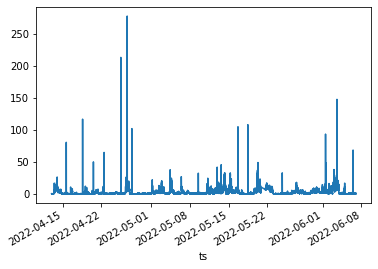

In [123]:
piera7100_df['piera7100_pm2p5_vals'].plot()

In [124]:
data = {}
data['ts'] = pd.to_datetime([datetime.fromtimestamp(int(ele['aq']['dt'])) for ele in ss if ele['aq'] is not None]).tz_localize(tz='US/Eastern')

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
df_main = pd.DataFrame({'RefSt': praxis_df["praxis_pm2p5_vals_adj"], 'Sensor_O1': piera7100_df["piera7100_pm2p5_vals"], 'Temp': df_weather["Temperature_C"], 'RelHum': df_weather["Humidity_%"]})

X = df_main[['Sensor_O1','Temp', 'RelHum']]
Y = df_main['RefSt']
X = X.fillna(X.mean())
Y = Y.fillna(Y.mean())

In [126]:
X_MLRtrain, X_MLRtest, Y_MLRtrain, Y_MLRtest = train_test_split(X, Y, test_size = 0.33, random_state = None, shuffle = False)

# ee = OneClassSVM(nu=0.51)
# yhat = ee.fit_predict(X_MLRtrain)
# # select all rows that are not outliers
# mask = yhat != -1
# X_MLRtrain, Y_MLRtrain = X_MLRtrain[mask], Y_MLRtrain[mask]


df_MLRtrain = pd.DataFrame({'RefSt': Y_MLRtrain, 'Sensor_O1': X_MLRtrain["Sensor_O1"],'Temp': X_MLRtrain["Temp"], 'RelHum': X_MLRtrain["RelHum"]})
df_MLRtest = pd.DataFrame({'RefSt': Y_MLRtest, 'Sensor_O1': X_MLRtest["Sensor_O1"],'Temp': X_MLRtest["Temp"], 'RelHum': X_MLRtest["RelHum"]})


In [127]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

def loss_functions(y_true, y_pred):
    print("Loss functions:")
    print("* R-squared =", r2_score(y_true, y_pred))
    print("* RMSE =", sqrt(mean_squared_error(y_true, y_pred)))
    print("* MAE =", mean_absolute_error(y_true, y_pred))


# %%
# Normalise sensor data
def normalize(col):
    μ = col.mean()
    sig = col.std()
    return (col - μ)/sig

df_main["normRefSt"] = normalize(df_main["RefSt"])
df_main["normSensor_O3"] = normalize(df_main["Sensor_O1"])
df_main["normTemp"] = normalize(df_main["Temp"])
df_main["normRelHum"] = normalize(df_main["RelHum"])

<AxesSubplot:xlabel='ts'>

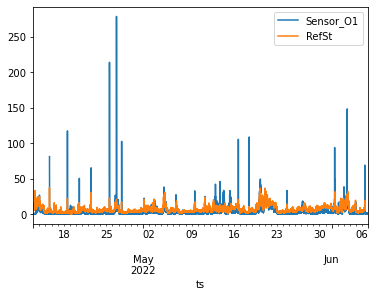

In [128]:
Sensor_O3_RefSt_factor = df_main[["Sensor_O1", "RefSt"]]
#Sensor_O3_RefSt_factor["RefSt"] = Sensor_O3_RefSt_factor["RefSt"]
Sensor_O3_RefSt_factor.plot()

Intercept: 
 -0.5327075316421297
Coefficients: 
 [0.40092065 0.27058917 0.02350833]
0.43699459036249977
Loss functions:
* R-squared = 0.507695321301944
* RMSE = 3.561172990378703
* MAE = 2.4870534237329704


<AxesSubplot:xlabel='ts'>

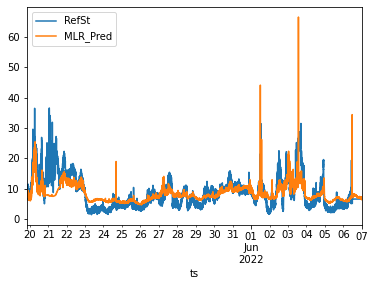

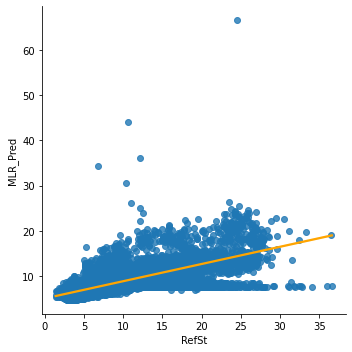

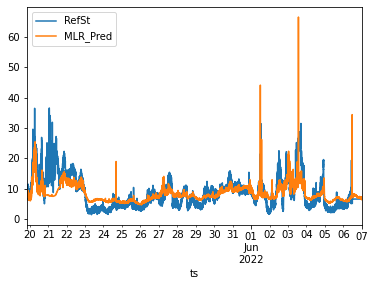

In [129]:
from sklearn.linear_model import LinearRegression

import seaborn as sns
# Model
lr = LinearRegression()


# Fit
lr.fit(X_MLRtrain, Y_MLRtrain)

# Get MLR coefficients
print('Intercept: \n', lr.intercept_)
print('Coefficients: \n', lr.coef_)

# Predict
df_MLRtest["MLR_Pred"] = lr.intercept_ + lr.coef_[0]*df_MLRtest["Sensor_O1"] + lr.coef_[1]*df_MLRtest["Temp"] + lr.coef_[2]*df_MLRtest["RelHum"]

# Plot linear
df_MLRtest[["RefSt", "MLR_Pred"]].plot()
print(lr.score(X_MLRtrain, Y_MLRtrain))


# Plot regression
sns.lmplot(x = 'RefSt', y = 'MLR_Pred', data = df_MLRtest, fit_reg = True, line_kws = {'color': 'orange'}) 

# Loss
loss_functions(y_true = df_MLRtest["RefSt"], y_pred = df_MLRtest["MLR_Pred"])
df_MLRtest[["RefSt", "MLR_Pred"]].plot()

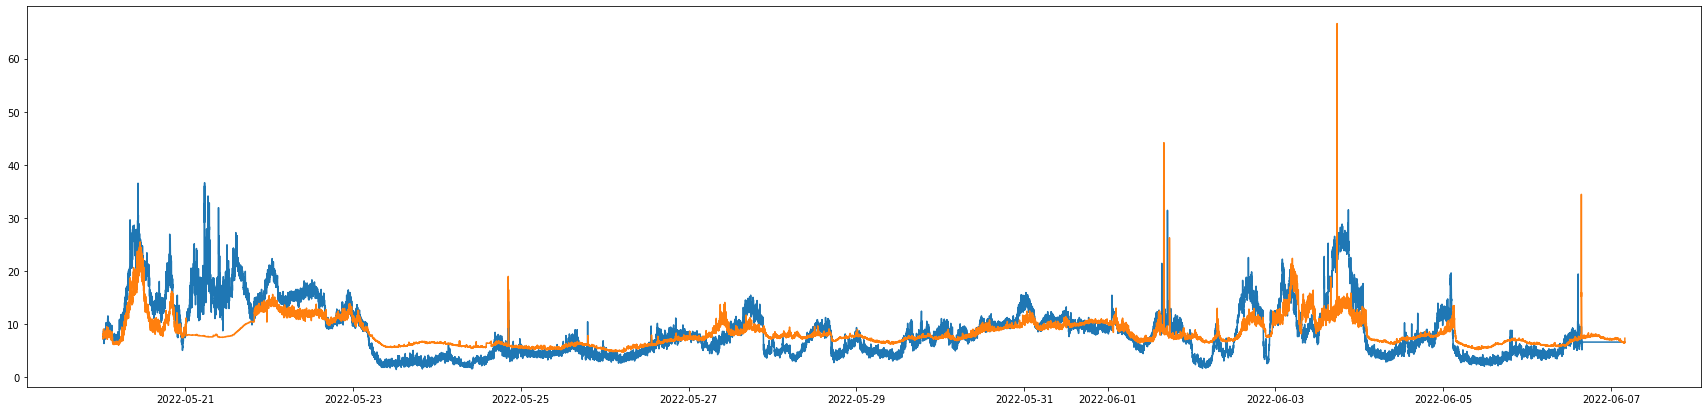

In [130]:
plt.figure(figsize=(30,7))
plt.plot(df_MLRtest[["RefSt", "MLR_Pred"]])

/Users/cm3580/miniconda/envs/sonycAQ/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
/Users/cm3580/miniconda/envs/sonycAQ/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Intercept: 
 [5.53020538]
Coefficients: 
 [0.06672486 1.14056586 0.57607529]
Iters: 
 5
{'alpha': 0.0001, 'average': False, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'loss': 'squared_loss', 'max_iter': 5, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Loss functions:
* R-squared = 0.1374463790685968
* RMSE = 4.713778167240859
* MAE = 3.2692852477758025


<AxesSubplot:xlabel='ts'>

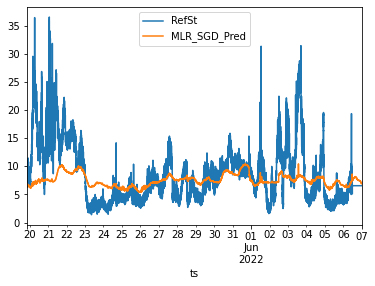

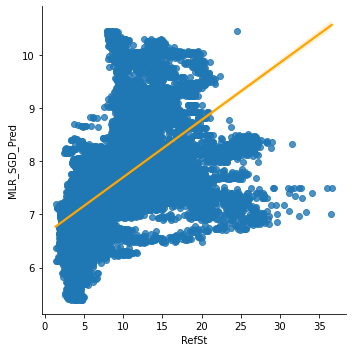

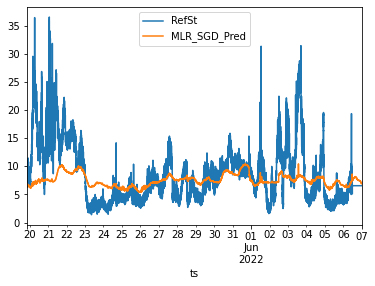

In [131]:
#With stochastic Gradient Descent
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
# Model
# sgdr = SGDRegressor(loss='squared_loss', alpha=.001, tol=1e-5)
sgdr = SGDRegressor(loss = 'squared_loss', max_iter = 5)

# Normalize
sc = StandardScaler()
X_MLR_SGDtrain = sc.fit_transform(X_MLRtrain)
X_MLR_SGDtest = sc.transform(X_MLRtest)

# Fit
sgdr.fit(X_MLR_SGDtrain, Y_MLRtrain)

# Get MLR coefficients
print('Intercept: \n', sgdr.intercept_)
print('Coefficients: \n', sgdr.coef_)
print('Iters: \n', sgdr.n_iter_)
print(sgdr.get_params())


# Predict
#df_MLRtest["MLR_SGD_Pred"] = sgdr.intercept_ + sgdr.coef_[0]*df_MLRtest["Sensor_O1"] + sgdr.coef_[1]*df_MLRtest["Temp"]+sgdr.coef_[2]*df_MLRtest["RelHum"]
df_MLRtest["MLR_SGD_Pred"] = sgdr.predict(X_MLR_SGDtest)

# Plot linear
df_MLRtest[["RefSt", "MLR_SGD_Pred"]].plot()


# Plot regression
sns.lmplot(x = 'RefSt', y = 'MLR_SGD_Pred', data = df_MLRtest, fit_reg = True, line_kws = {'color': 'orange'}) 

# Loss
loss_functions(y_true = df_MLRtest["RefSt"], y_pred = df_MLRtest["MLR_SGD_Pred"])
df_MLRtest[["RefSt", "MLR_SGD_Pred"]].plot()

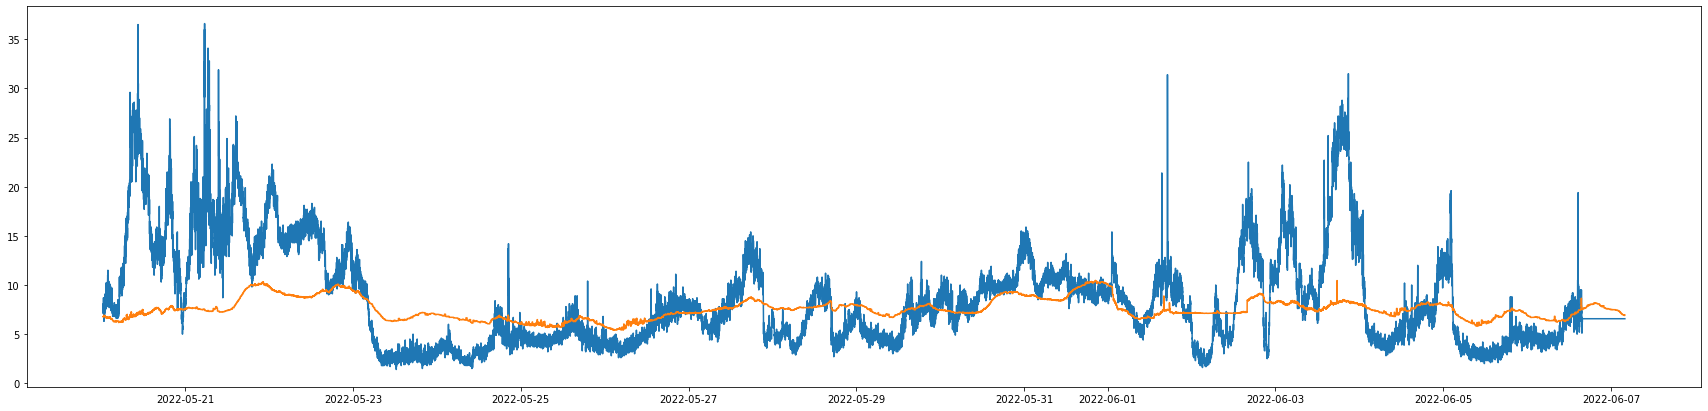

In [132]:
plt.figure(figsize=(30,7))
plt.plot(df_MLRtest[["RefSt", "MLR_SGD_Pred"]])

100%|███████████████████████████████████████| 1000/1000 [47:12<00:00,  2.83s/it]


Best K num: 639
Best RMSE: 3.7085
Loss functions:
* R-squared = 0.4661293831366703
* RMSE = 3.7084642664918945
* MAE = 2.4363022308296602


<AxesSubplot:xlabel='ts'>

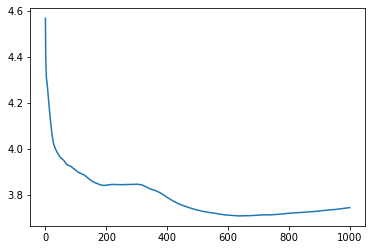

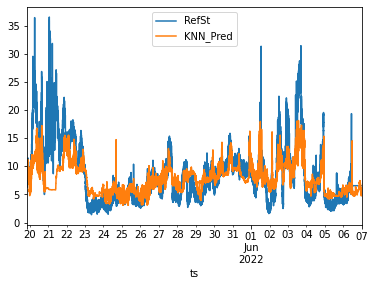

In [164]:
# %%
# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics

rmse_val = []

K_check_num = 1000

for K in tqdm(range(K_check_num)):
    K = K + 1
    knn = KNeighborsRegressor(n_neighbors = K)
    knn.fit(X_MLRtrain, Y_MLRtrain)
    df_MLRtest["KNN_Pred"] = knn.predict(X_MLRtest)
    error = sqrt(mean_squared_error(df_MLRtest["RefSt"], df_MLRtest["KNN_Pred"]))
    rmse_val.append(error) #store rmse values
    #     print('RMSE value for k= ' , K , 'is:', error)

plt.plot(rmse_val)
best_k_val = rmse_val.index(min(rmse_val)) + 1
print('Best K num: %i' % best_k_val)
print('Best RMSE: %.4f' % rmse_val[best_k_val - 1])

# Model
knn = KNeighborsRegressor(n_neighbors = best_k_val)

# Fit
knn.fit(X_MLRtrain, Y_MLRtrain)

with open('knn_pickle_file_sonycAQ', 'wb') as knnPickle:
    pickle.dump(knn, knnPickle)

# Predict
df_MLRtest["KNN_Pred"] = knn.predict(X_MLRtest)

# Loss
loss_functions(y_true = df_MLRtest["RefSt"], y_pred = df_MLRtest["KNN_Pred"])
df_MLRtest[["RefSt", "KNN_Pred"]].plot()

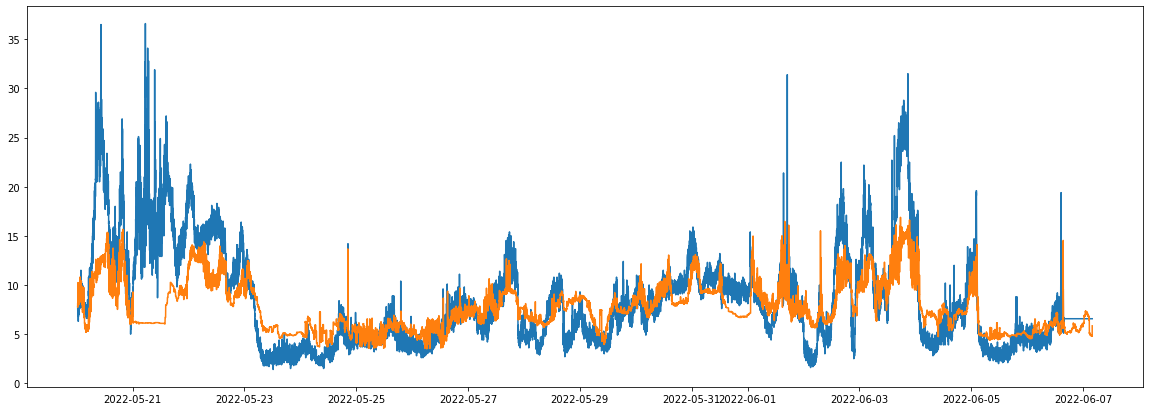

In [160]:
plt.figure(figsize=(20,7))
plt.plot(df_MLRtest[["RefSt", "KNN_Pred"]])

In [24]:
# # %% uncomment to run KNN with hyper parameters
# # K-Nearest Neighbor stats vs. hyperparameters
# def knn_stats():
#     knn_aux = pd.DataFrame({'RefSt': Y_MLRtest})

#     n_neighbors = [*range(1, 151, 1)]
#     r_squared = []
#     rmse = []
#     mae = []
#     time_ms = []

#     for i in n_neighbors:
#         # Model
#         knn = KNeighborsRegressor(n_neighbors=i)

#         # Fit
#         start_time = float(datetime.now().strftime('%S.%f'))
#         knn.fit(X_MLRtrain, Y_MLRtrain)
#         end_time = float(datetime.now().strftime('%S.%f'))
#         execution_time = (end_time - start_time) * 1000

#         # Predict
#         knn_aux["KNN_Pred"] = knn.predict(X_MLRtest)
        

#         # Loss
#         r_squared.append(r2_score(knn_aux["RefSt"], knn_aux["KNN_Pred"]))
#         rmse.append(mean_squared_error(knn_aux["RefSt"], knn_aux["KNN_Pred"]))
#         mae.append(mean_absolute_error(knn_aux["RefSt"], knn_aux["KNN_Pred"]))
#         time_ms.append(execution_time)

#     knn_stats = pd.DataFrame({'k': n_neighbors, 'r_squared': r_squared, 'rmse': rmse, 'mae': mae, 'time_ms': time_ms})
#     knn_stats = knn_stats.set_index('k') # index column (X axis for the plots)
#     print(knn_stats)
#     plt.plot(knn_aux[["RefSt", "KNN_Pred"]])
#     # plot
#     # knn_stats[["r_squared"]].plot()
#     # knn_stats[["rmse"]].plot()
#     # knn_stats[["mae"]].plot()
#     # knn_stats[["time_ms"]].plot()
    
# knn_stats()

<AxesSubplot:xlabel='ts'>

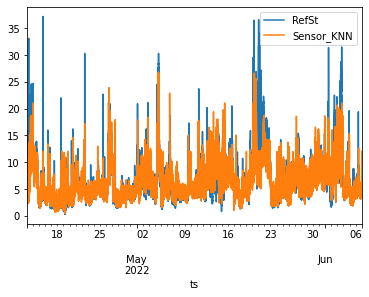

In [47]:
df_KNN = pd.DataFrame({'RefSt': praxis_df["praxis_pm2p5_vals_adj"], 'Sensor_O1': piera7100_df["piera7100_pm2p5_vals"], 'Temp': df_weather["Temperature_C"], 'RelHum': df_weather["Humidity_%"]})
df_KNN["KNN"] = knn.predict(X)
df_KNN = pd.DataFrame({'RefSt': praxis_df["praxis_pm2p5_vals_adj"], 'Sensor_KNN': df_KNN["KNN"]})
Sensor_plot_KNN = df_KNN[["RefSt","Sensor_KNN"]]
Sensor_plot_KNN.plot()

Loss functions:
* R-squared = 0.3674265036398294
* RMSE = 16.295330391208513
* MAE = 2.627783799604692
Feature importances:
 [('Sensor_O1', 0.9330393620266004), ('Temp', 0.03438658026297792), ('RelHum', 0.03257405771042174)]


<AxesSubplot:xlabel='ts'>

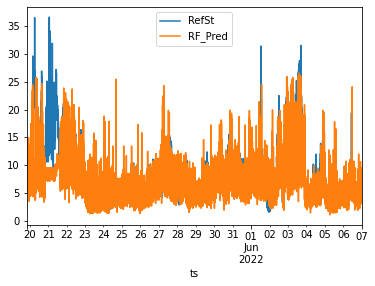

In [48]:
# %%
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Model
rf = RandomForestRegressor(n_estimators = 20 ,random_state = 0)

# Fit
rf.fit(X_MLRtrain, Y_MLRtrain)

# Predict
df_MLRtest["RF_Pred"] = rf.predict(X_MLRtest)
# print(df_MLRtest)

# Plot linear
# df_MLRtest[["RefSt", "RF_Pred"]].plot()
# plt.xticks(rotation = 20)

# Plot regression
# sns.lmplot(x = 'RefSt', y = 'RF_Pred', data = df_MLRtest, fit_reg = True, line_kws = {'color': 'orange'}) 

# Loss
loss_functions(y_true = df_MLRtest["RefSt"], y_pred = df_MLRtest["RF_Pred"])

# RF feature importances
print('Feature importances:\n', list(zip(X.columns, rf.feature_importances_)))
df_MLRtest[["RefSt", "RF_Pred"]].plot()

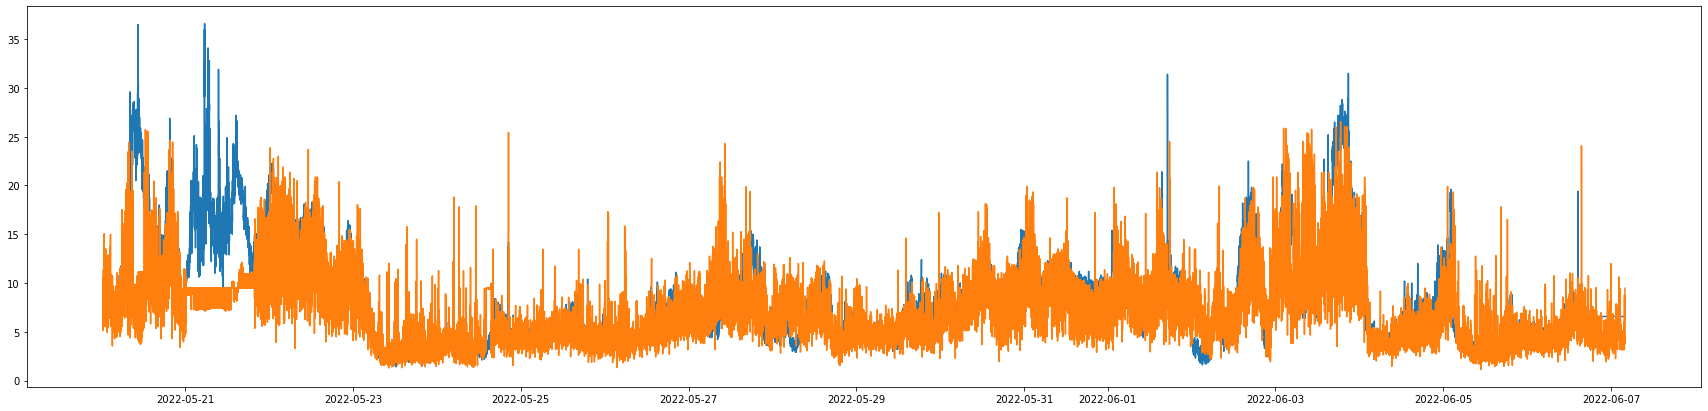

In [49]:
plt.figure(figsize=(30,7))
plt.plot(df_MLRtest[["RefSt","RF_Pred"]])

<AxesSubplot:xlabel='ts'>

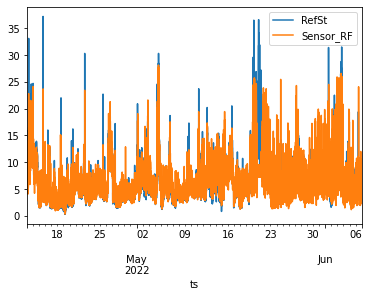

In [50]:
df_RF = pd.DataFrame({'RefSt': praxis_df["praxis_pm2p5_vals_adj"], 'Sensor_O1': piera7100_df["piera7100_pm2p5_vals"], 'Temp': df_weather["Temperature_C"], 'RelHum': df_weather["Humidity_%"]})
df_RF["RF"] = rf.predict(X)
df_RF = pd.DataFrame({'RefSt': praxis_df["praxis_pm2p5_vals_adj"], 'Sensor_RF': df_RF["RF"]})
Sensor_plot_RF = df_RF[["RefSt", "Sensor_RF"]]
Sensor_plot_RF.plot()

In [29]:
# # %%
# # Kernel Regression
# # from sklearn_extensions.kernel_regression import KernelRegression
# from sklearn.kernel_ridge import KernelRidge

# # Models
# kr_rbf = KernelRidge(kernel = "rbf")
# kr_poly = KernelRidge(kernel = "poly", degree = 4)

# # Fit
# kr_rbf.fit(X_MLRtrain, Y_MLRtrain)
# kr_poly.fit(X_MLRtrain, Y_MLRtrain)

# # Predict
# df_MLRtest["KR_RBF_Pred"] = kr_rbf.predict(X_MLRtest)
# df_MLRtest["KR_Poly_Pred"] = kr_poly.predict(X_MLRtest)

# # Plot linear
# df_MLRtest[["RefSt", "KR_RBF_Pred", "KR_Poly_Pred"]].plot()
# plt.xticks(rotation=20)

# # Plot regression
# sns.lmplot(x = 'RefSt', y = 'KR_RBF_Pred', data = df_MLRtest, fit_reg = True, line_kws = {'color': 'orange'}) 
# sns.lmplot(x = 'RefSt', y = 'KR_Poly_Pred', data = df_MLRtest, fit_reg = True, line_kws = {'color': 'orange'}) 

# # Loss
# loss_functions(y_true = df_MLRtest["RefSt"], y_pred = df_MLRtest["KR_RBF_Pred"])
# loss_functions(y_true = df_MLRtest["RefSt"], y_pred = df_MLRtest["KR_Poly_Pred"])


In [30]:
# # %%
# # Gaussian Process
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct, WhiteKernel

# # Kernels definition
# # rbf = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-10, 1e10)) * RBF(length_scale=1.0, length_scale_bounds=(1e-10, 1e10))
# rbf = ConstantKernel() * RBF()
# dpwh = DotProduct() + WhiteKernel()

# # Models
# gp_rbf = GaussianProcessRegressor(kernel = rbf, alpha = 150, random_state = 0)
# gp_dpwh = GaussianProcessRegressor(kernel = dpwh, alpha = 150, random_state = 0)

# # Fit
# gp_rbf.fit(X_MLRtrain, Y_MLRtrain)
# gp_dpwh.fit(X_MLRtrain, Y_MLRtrain)

# # Predict
# df_MLRtest["GP_RBF_Pred"] = gp_rbf.predict(X_MLRtest)
# df_MLRtest["GP_DPWK_Pred"] = gp_dpwh.predict(X_MLRtest)

# # Obtain optimized kernel parameters
# # l = gp.kernel_.k2.get_params()['length_scale']
# # sigma_f = np.sqrt(gp.kernel_.k1.get_params()['constant_value'])

# # Print parameters
# print("RBF params", gp_rbf.get_params())
# print("Dot params", gp_dpwh.get_params())

# # Plot linear
# df_MLRtest[["RefSt", "GP_RBF_Pred", "GP_DPWK_Pred"]].plot()
# plt.xticks(rotation = 20)

# # Plot regression
# sns.lmplot(x = 'RefSt', y = 'GP_RBF_Pred', data = df_MLRtest, fit_reg = True, line_kws = {'color': 'orange'}) 
# sns.lmplot(x = 'RefSt', y = 'GP_DPWK_Pred', data = df_MLRtest, fit_reg = True, line_kws = {'color': 'orange'}) 

# # Loss
# loss_functions(y_true = df_MLRtest["RefSt"], y_pred = df_MLRtest["GP_RBF_Pred"])
# loss_functions(y_true = df_MLRtest["RefSt"], y_pred = df_MLRtest["GP_DPWK_Pred"])

Intercept: 
 [-54.81080898]
Loss functions:
* R-squared = 0.38058394720516364
* RMSE = 15.956389712798037
* MAE = 2.4708670413874088


<AxesSubplot:xlabel='ts'>

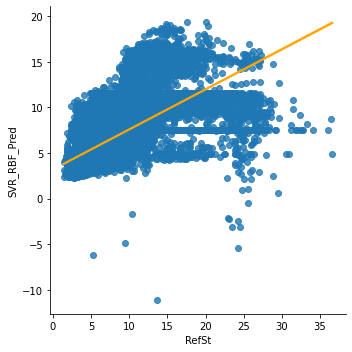

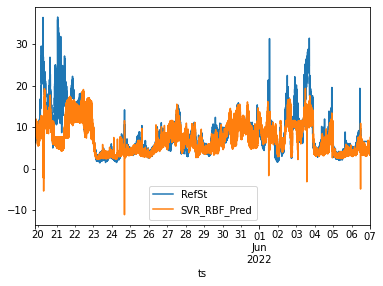

In [51]:
##Using radial basis function kernel
# Support Vector Regression
from sklearn.svm import SVR

# Models
svr_rbf = SVR(kernel = 'rbf', C = 1e3)#, gamma=0.1)

# Fit
svr_rbf.fit(X_MLRtrain, Y_MLRtrain)

print('Intercept: \n', svr_rbf.intercept_)

# Predict
df_MLRtest["SVR_RBF_Pred"] = svr_rbf.predict(X_MLRtest)

# Plot regression
sns.lmplot(x = 'RefSt', y = 'SVR_RBF_Pred', data = df_MLRtest, fit_reg = True, line_kws = {'color': 'orange'}) 

# Loss
loss_functions(y_true = df_MLRtest["RefSt"], y_pred = df_MLRtest["SVR_RBF_Pred"])

df_MLRtest[["RefSt", "SVR_RBF_Pred"]].plot()

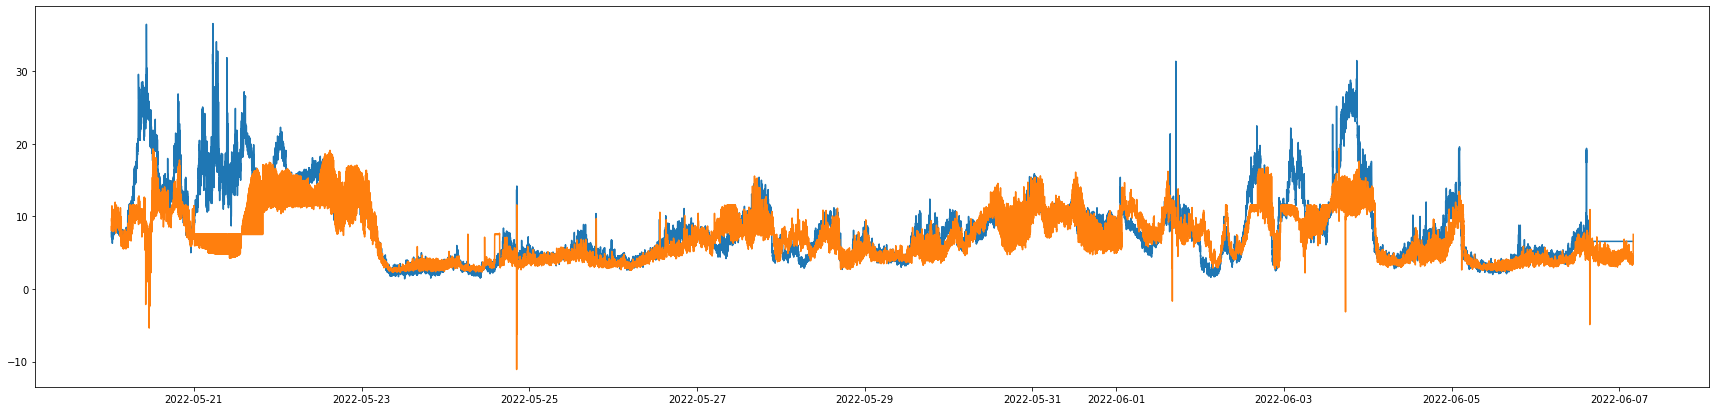

In [52]:
plt.figure(figsize=(30,7))
plt.plot(df_MLRtest[["RefSt","SVR_RBF_Pred"]])

In [33]:
# # Not Ideal as it will take a lot of time to compute
# # Support Vector Regression
# from sklearn.svm import SVR

# # Models
# svr_lin = SVR(kernel = 'linear', C = 1e3)


# # Fit

# svr_lin.fit(X_MLRtrain, Y_MLRtrain)

# print('Intercept: \n', svr_lin.intercept_)
# # print('Coefficients: \n', svr_lin.coef_)

# # Predict
# df_MLRtest["SVR_Line_Pred"] = svr_lin.predict(X_MLRtest)


# # Plot regression
# sns.lmplot(x = 'RefSt', y = 'SVR_Line_Pred', data = df_MLRtest, fit_reg = True, line_kws = {'color': 'orange'}) 


# # Loss
# loss_functions(y_true = df_MLRtest["RefSt"], y_pred = df_MLRtest["SVR_Line_Pred"])

# df_MLRtest[["RefSt", "SVR_Line_Pred"]].plot()

In [34]:
# # # Support Vector Regression using poly (Not Ideal as it takes a lot of time to train)
# from sklearn.svm import SVR

# # Models
# svr_poly = SVR(kernel = 'poly', C = 1e3, degree = 3)

# # Fit
# svr_poly.fit(X_MLRtrain, Y_MLRtrain)
# print('Intercept: \n', svr_poly.intercept_)
# #print('Coefficients: \n', svr_poly.coef_)

# # Predict
# df_MLRtest["SVR_Poly_Pred"] = svr_poly.predict(X_MLRtest)

# # Plot regression

# sns.lmplot(x = 'RefSt', y = 'SVR_Poly_Pred', data = df_MLRtest, fit_reg = True, line_kws = {'color': 'orange'}) 

# # Loss

# loss_functions(y_true = df_MLRtest["RefSt"], y_pred = df_MLRtest["SVR_Poly_Pred"])
# df_MLRtest[["RefSt", "SVR_Poly_Pred"]].plot()

In [35]:
# df_SVR = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_O1': canary_df["canary_pm2p5_vals"], 'Temp': canary_df["canary_temp"], 'RelHum': canary_df["canary_rh"]})
# df_SVR["SVR_rbf"] = svr_rbf.predict(X)
# # df_SVR["SVR_lin"] = svr_lin.predict(X)
# # df_SVR["SVR_poly"] = svr_poly.predict(X)
# df_SVR = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_RF': df_SVR["SVR_rbf"]})
# # df_SVR = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_RF_rbf': df_SVR["SVR_rbf"], 'Sensor_RF_lin': df_SVR["SVR_lin"], 'Sensor_RF_poly': df_SVR["SVR_poly"]})
# Sensor_plot_SVR = df_SVR[["Sensor_RF", "RefSt"]]
# Sensor_plot_SVR.plot()

2.4.0
Epoch 1/20


2022-07-01 13:27:30.737976: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-01 13:27:30.847250: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


10613/10613 [==============================] - 11s 952us/step - loss: 6.6828
Epoch 2/20
10613/10613 [==============================] - 11s 1ms/step - loss: 5.1657
Epoch 3/20
10613/10613 [==============================] - 11s 990us/step - loss: 5.0345
Epoch 4/20
10613/10613 [==============================] - 11s 991us/step - loss: 4.9501
Epoch 5/20
10613/10613 [==============================] - 10s 964us/step - loss: 4.9287
Epoch 6/20
10613/10613 [==============================] - 11s 1ms/step - loss: 4.8961
Epoch 7/20
10613/10613 [==============================] - 11s 1ms/step - loss: 4.7028
Epoch 8/20
10613/10613 [==============================] - 10s 967us/step - loss: 4.7816
Epoch 9/20
10613/10613 [==============================] - 11s 994us/step - loss: 4.7255
Epoch 10/20
10613/10613 [==============================] - 10s 935us/step - loss: 4.7361
Epoch 11/20
10613/10613 [==============================] - 10s 932us/step - loss: 4.7716
Epoch 12/20
10613/10613 [======================

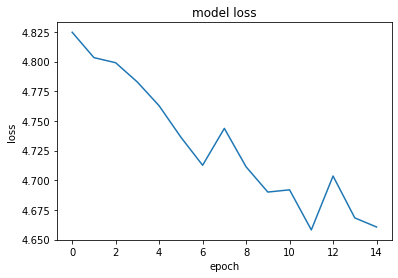

                              RefSt  Sensor_O1       Temp     RelHum  \
ts                                                                     
2022-05-19 20:25:00-04:00  7.800000   3.690628  17.143404  62.066929   
2022-05-19 20:26:00-04:00  7.500000   3.230425  17.143404  62.066929   
2022-05-19 20:27:00-04:00  7.300000   3.972194  17.143404  62.066929   
2022-05-19 20:28:00-04:00  7.100000   4.844704  17.143404  62.066929   
2022-05-19 20:29:00-04:00  7.400000   4.974449  16.940000  81.000000   
...                             ...        ...        ...        ...   
2022-06-06 23:56:00-04:00  6.567002   0.727292  17.143404  62.066929   
2022-06-06 23:57:00-04:00  6.567002   0.778663  17.143404  62.066929   
2022-06-06 23:58:00-04:00  6.567002   0.993986  17.143404  62.066929   
2022-06-06 23:59:00-04:00  6.567002   0.780984  20.670000  48.000000   
2022-06-07 00:00:00-04:00  6.567002   2.861778  17.143404  62.066929   

                           MLR_Pred  MLR_SGD_Pred   KNN_Pred   

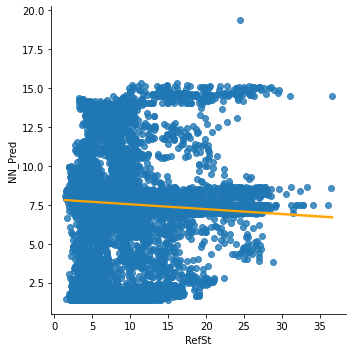

In [54]:
# %%
# Neural Network
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, InputLayer
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

# Normalise data
sc = StandardScaler()
X_train_NN = sc.fit_transform(X_MLRtrain)
X_test_NN = sc.transform(X_MLRtest)
Y_MLRtrain_NN = Y_MLRtrain
# Model
nn = Sequential()

# Model - Layers
nn.add(InputLayer(input_shape = (3))) # Input layer
nn.add(Dense(units = 64, activation = 'relu')) # 1st hidden layer
nn.add(Dense(units = 64, activation = 'relu')) # 2nd hidden layer
nn.add(Dense(units = 64, activation = 'relu')) # 3rd hidden layer
nn.add(Dense(units = 64, activation = 'relu')) # 4th hidden layer
nn.add(Dense(units = 64, activation = 'relu')) # 5th hidden layer
nn.add(Dense(units = 64, activation = 'relu')) # 6th hidden layer
nn.add(Dense(units = 64, activation = 'relu')) # 7th hidden layer
nn.add(Dense(units = 1)) # Output layer

nn.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fit
history = nn.fit(X_train_NN, Y_MLRtrain_NN, batch_size = 5, epochs = 20)

# Plot loss
plt.plot(history.history['loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Predict
df_MLRtest["NN_Pred"] = nn.predict(X_MLRtest)
print(df_MLRtest)

# Plot linear
# df_MLRtest[["RefSt", "NN_Pred"]].plot()
# plt.xticks(rotation=20)

# Plot regression
sns.lmplot(x = 'RefSt', y = 'NN_Pred', data = df_MLRtest, fit_reg = True, line_kws = {'color': 'orange'}) 

# Loss
loss_functions(y_true = df_MLRtest["RefSt"], y_pred = df_MLRtest["NN_Pred"])

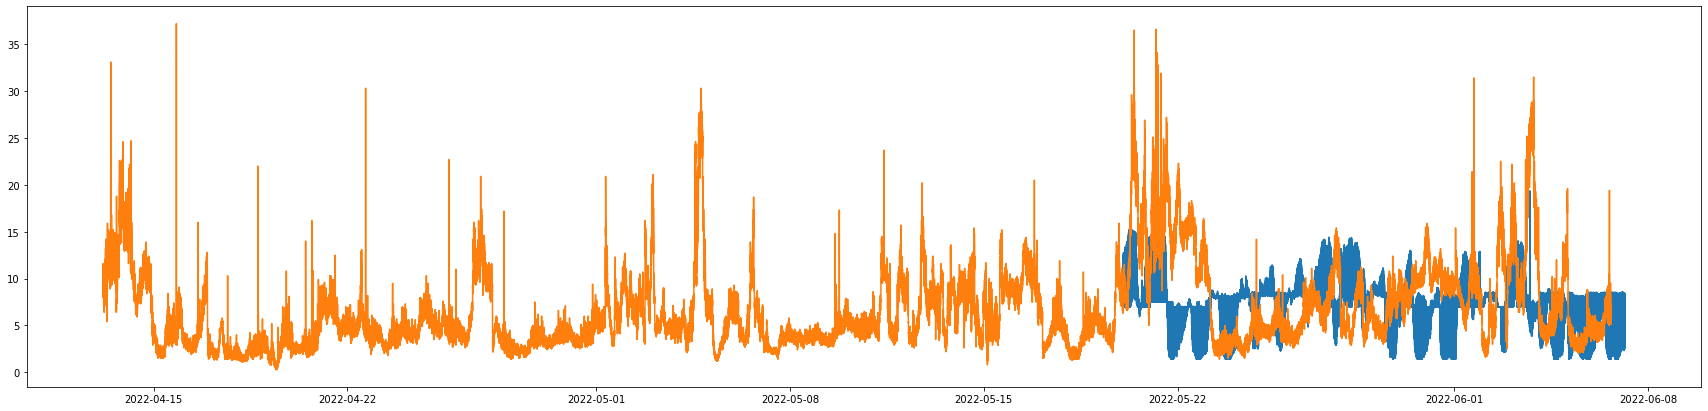

In [55]:
plt.figure(figsize=(30,7))
# df_SVR = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_O1': canary_df["canary_pm2p5_vals"], 'Temp': canary_df["canary_temp"], 'RelHum': canary_df["canary_rh"]})
# df_SVR["SVR_rbf"] = svr_rbf.predict(X)
# df_SVR["SVR_lin"] = svr_lin.predict(X)
# df_SVR["SVR_poly"] = svr_poly.predict(X)
df_NN = pd.DataFrame({'RefSt': praxis_df["praxis_pm2p5_vals_adj"], 'Sensor_NN': df_MLRtest["NN_Pred"]})
# df_SVR = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_RF_rbf': df_SVR["SVR_rbf"], 'Sensor_RF_lin': df_SVR["SVR_lin"], 'Sensor_RF_poly': df_SVR["SVR_poly"]})
Sensor_plot_NN = df_NN[["Sensor_NN", "RefSt"]]
plt.plot(Sensor_plot_NN)